# **Recomendador de películas**

**Autor:** Jorge Galeano Maté

## Descripción

Construir un sistema de recomendación de películas que combine técnicas de filtrado colaborativo y procesamiento de lenguaje natural (LLM). El 
sistema permitirá a los usuarios describir la película que desean ver en lenguaje natural y recibir recomendaciones personalizadas.


## Datos

Se utilizarán tres archivos CSV par aconstruir el sistema:

- `ratings.csv`: valoraciones de los usuarios a las películas.

- `movies.csv`: información sobre las películas (título, géneros, etc.).

- `links.csv`: enlaces entre los ID de las películas en el conjunto de datos y los ID de IMDb.


## Instrucciones

### Paso 1: Construir un filtro colaborativo

Construye un filtro colaborativo haciendo uso de `ratings.csv`.

Puedes elegir entre:

- Item-to-item.

- User-to-user.

- Matriz factorizada con librería `surprise`.

- Red neuronal con `tensorflow` para simular la factorización de matrices.

_Nota: se valorará más la construcción de una red neuronal._

### Paso 2: Optimización del modelo

Optimizar los hiperparámetros del modelo de filtrado colaborativo. Probar diferentes modelos y seleccionar el que mejor rendimiento tenga en un conjunto de validación.

### Paso 3: Agente LLM para la selección de candidatos

- **3.1.** Recibir la descripción de la película deseada por el usuario (texto libre).

- **3.2.** Obtener el ID del usuario y, utilizando el filtro colaborativo, predecir las valoraciones para las películas no vistas.

- **3.3.** Seleccionar las 10 películas con las mejores valoraciones predichas.

- **3.4.** Extraer información de las 10 películas (géneros y sinopsis) utilizando la librería IMDb.

### Paso 4: Agente LLM para la explicación de la recomendación

Si alguna de las 10 películas coincide con la descripción del usuario, generar una explicación de por qué se recomienda esa película, considerando la descripción del usuario, la sinopsis y los géneros.

### Paso 5: Agente LLM para recomendación genérica

Si ninguna de las 10 películas coincide con la descripción del usuario, recomendar una película genérica que se ajuste a la descripción. Generar una explicación de por qué se recomienda.

---

# Pasos previos

## Configuración del entorno e importación de librerías

Configuramos el **entorno de trabajo** e **importamos todas las librerías necesarias**. 

In [2]:
# Variables de entorno
import sys
import os
import warnings
import getpass

SYS_PATH = os.getenv('SYS_PATH')
if SYS_PATH:
    sys.path.append(SYS_PATH)
else:
    warnings.warn('SYS_PATH no está presente en archivo .env', UserWarning)
    SYS_PATH = os.environ['SYS_PATH'] = getpass.getpass('Introduce la ruta del repositorio: ')

from utils.model_functions import MatrixFactorization,\
        codificar_usuario, descodificar_usuario, codificar_pelicula, descodificar_pelicula, \
        revisar_match_llm_1, elegir_pelicula_llm_2, elegir_pelicula_llm_3

OMDB_API_KEY = os.getenv('OMDB_API_KEY')
if not OMDB_API_KEY:
    warnings.warn('OMDB_API_KEY no está presente en archivo .env', UserWarning)
    OMDB_API_KEY = os.environ['OMDB_API_KEY'] = getpass.getpass('Introduce tu OMDb API key: ')

GROQ_API_KEY = os.getenv('GROQ_API_KEY')
if not GROQ_API_KEY:
    warnings.warn('GROQ_API_KEY no está presente en archivo .env', UserWarning)
    GROQ_API_KEY = os.environ['GROQ_API_KEY'] = getpass.getpass('Introduce tu Groq API key: ')

# Análisis de datos
import pandas as pd
from skrub import TableReport
import numpy as np

# Modelado
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import optuna
import pickle

# Visualización
import matplotlib.pyplot as plt

# API
import requests

## EDA

En primer lugar, realizaremos un análisis de los datos para comprobar que están limpios y observar las distribuciones. Extraemos los datos con Pandas a partir de los archivos .csv y los mostramos con TableReport.

In [3]:
df_links_init = pd.read_csv('./datos/links.csv')
df_movies_init = pd.read_csv('./datos/movies.csv')
df_ratings_init = pd.read_csv('./datos/ratings.csv')

In [4]:
TableReport(df_links_init)

Processing column   3 / 3


<TableReport: use .open() to display>

In [5]:
TableReport(df_movies_init)

Processing column   3 / 3


<TableReport: use .open() to display>

In [6]:
TableReport(df_ratings_init)

Processing column   4 / 4


<TableReport: use .open() to display>

Revisando los datos de los datasets, observamos varios puntos de interés:

- Solo existen 8 nulos en códigos de TMDb, pero ninguno de IMDb. Usaremos solo los códigos del segundo.

- Las distribuciones de los datos siguen patrones lógicos.

- Las valoraciones tienen un rango de 0.5 a 5, con incrementos de 0.5, y sin películas sin valorar.

Debido a que no hay valores ausentes significativos, los datos son correctos y el formato es consistente, no se considera necesario hacer limpieza.

---

# Paso 1: Construir un filtro colaborativo

## Preprocesamiento

Las capas de embedding en TensorFlow requieren índices consecutivos comenzando desde 0. Esta conversión es necesaria para optimizar el uso de memoria y garantizar el funcionamiento correcto del modelo. En este caso, los userId son consecutivos, pero comienzan desde 1; y los movieId no lo son.

Pasaremos usuarios y películas únicos a índices consecutivos para trabajar con la red neuronal. Asimismo, guardaremos un decodificador para pasar de nuevo de esos tokens a los códigos reales de usuarios y películas.

Trabajaremos sobre una copia para mantener el dataframe original antes de procesarlo para la red neuronal.

In [7]:
df_ratings = df_ratings_init.copy()

# Verificar userId
print('USER-ID:')
print(f'   Antes: Rango {df_ratings['userId'].min()} - {df_ratings['userId'].max()}')

# Crear mapeo consecutivo desde 0 en userId
user_idx, unique_users = pd.factorize(df_ratings['userId'])
df_ratings['users'] = user_idx

# Mostrar nuevo rango de users
print(f'   Después: Rango {df_ratings['users'].min()} - {df_ratings['users'].max()}')

# Verificar movieId
print('MOVIE-ID:')
print(f'   Antes: Rango {df_ratings['movieId'].min()} - {df_ratings['movieId'].max()}')

# Crear mapeo consecutivo desde 0 en movieId
movie_idx, unique_movies = pd.factorize(df_ratings['movieId'])
df_ratings['movies'] = movie_idx

# Mostrar nuevo rango de movies
print(f'   Después: Rango {df_ratings['movies'].min()} - {df_ratings['movies'].max()}')

USER-ID:
   Antes: Rango 1 - 610
   Después: Rango 0 - 609
MOVIE-ID:
   Antes: Rango 1 - 193609
   Después: Rango 0 - 9723


In [8]:
df_ratings.head()

,userId,movieId,rating,timestamp,users,movies
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [9]:
# Guardar dimensiones para red neuronal
n_users = len(unique_users)
n_movies = len(unique_movies)
print(f'Dimensiones para la red neuronal:')
print(f'   Número de usuarios: {n_users}')
print(f'   Número de películas: {n_movies}')

Dimensiones para la red neuronal:
   Número de usuarios: 610
   Número de películas: 9724


Guardamos los mapeos para codificar y descodificar los ID, ya que nosotros trabajamos con los ID originales, pero el modelo usará los índices consecutivos.

In [10]:
# Codificadores
user_to_idx = dict(zip(unique_users, range(len(unique_users))))
movie_to_idx = dict(zip(unique_movies, range(len(unique_movies))))

# Decodificadores
idx_to_user = dict(zip(range(len(unique_users)), unique_users))
idx_to_movie = dict(zip(range(len(unique_movies)), unique_movies))

Para usarlos más adelante, usaremos las funciones añadidas en `model_functions.py`, a las cuales pasaremos el ID o el index, y devolverá el que corresponda.

Adicionalmente, guardamos los mapeos en un archivo pickle para tenerlos disponibles en caso de ser necesarios.

In [11]:
with open('./models/mapeos.pkl', 'wb') as f:
    pickle.dump({
        'user_to_idx': user_to_idx,
        'idx_to_user': idx_to_user,
        'movie_to_idx': movie_to_idx,
        'idx_to_movie': idx_to_movie,
        'n_users': n_users,
        'n_movies': n_movies
    }, f)

## Análisis de densidad

De acara a utilizar una red neuronal, debemos verificar que la densidad de los datos sea suficiente para que se pueda entrenar correctamente.

Existe el problema del "cold start", en donde la red neuronal es incapaz de aprender embeddings de calidad cuando las muestras son pequeñas y los usuarios y películas tienen pocas interacciones. Si la densidad es demasiado baja (menor del 1%), la red neuronal no puede generalizar patrones correctamente y habría que seleccionar muestras con suficientes ratings.

Evaluamos la densidad para comprobar que esté por encima del 1%.

In [12]:
n_ratings = len(df_ratings)
densidad = n_ratings / (n_users * n_movies)

print(f'Estado:')
print(f'   Usuarios: {n_users:,} | Películas: {n_movies:,} | Ratings: {n_ratings:,}')
print(f'   Densidad: {densidad:.6f} ({densidad*100:.2f}%)')

Estado:
   Usuarios: 610 | Películas: 9,724 | Ratings: 100,836
   Densidad: 0.017000 (1.70%)


Como podemos observar, la densidad está por encima del 1%, por lo que podemos proceder con la implementación de la red neuronal.

Por último, dividimos los datos en predictores y objetivo. A su vez, dividimos en grupos de entrenamiento y de test, mezclando los datos para que no se escojan por orden.

In [13]:
X = df_ratings[['users', 'movies']].to_numpy()
y = df_ratings['rating'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)

# Paso 2: Optimización del modelo

Para simular la matriz de factorización, debemos construir la red neuronal. Para ello, usamos la función `MatrixFactorization` creada en `model_functions.py` para construirla, lo aplicamos y compilamos el modelo para que use el **error cuadrático medio (MSE)** como métrica de pérdida, junto con el **optimizador Adam**.

Para optimizar los hiperparámetros, utilizamos la librería **Optuna**, que inteligentemente elige entre los parámetros dados los mejores para el modelo. Para evitar grandes costes y mucho tiempo de entrenamiento, probamos con 10 epochs para sacar los valores óptimos. Ajustamos algunos valores para el **embedding_size** (tamaño de los vectores), el **learning_rate**, el **batch_size** y el **reg_l2** (regularización L2).

In [14]:
def objective(trial):

    # Valores entre los que elegir
    embedding_size = trial.suggest_categorical('embedding_size', [8, 16, 32])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-5])
    batch_size = trial.suggest_categorical('batch_size', [64, 128])
    reg_l2 = trial.suggest_categorical('reg_l2', [1e-6, 1e-4])

    # Modelo para compilar
    model = MatrixFactorization(n_users, n_movies, embedding_size, reg_l2)
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=learning_rate))

    # Entrenamiento del modelo con los hiperparámetros elegidos
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=10,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    return min(history.history['val_loss'])

# Realización del estudio de Optuna
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=20)

print(f'\nMejores hiperparámetros: {study.best_params}')
print(f'Mejor MSE: {study.best_value:.4f}')

[I 2025-07-08 13:40:36,173] A new study created in memory with name: no-name-2ef6fbcc-a91b-4531-afec-366fa58db126
[I 2025-07-08 13:41:25,355] Trial 0 finished with value: 0.7914763689041138 and parameters: {'embedding_size': 16, 'learning_rate': 0.001, 'batch_size': 64, 'reg_l2': 0.0001}. Best is trial 0 with value: 0.7914763689041138.
[I 2025-07-08 13:41:53,227] Trial 1 finished with value: 1.602015733718872 and parameters: {'embedding_size': 16, 'learning_rate': 1e-05, 'batch_size': 128, 'reg_l2': 0.0001}. Best is trial 0 with value: 0.7914763689041138.
[I 2025-07-08 13:43:18,628] Trial 2 finished with value: 0.8024975061416626 and parameters: {'embedding_size': 32, 'learning_rate': 0.001, 'batch_size': 64, 'reg_l2': 1e-06}. Best is trial 0 with value: 0.7914763689041138.
[I 2025-07-08 13:43:36,812] Trial 3 finished with value: 1.612328290939331 and parameters: {'embedding_size': 8, 'learning_rate': 1e-05, 'batch_size': 128, 'reg_l2': 0.0001}. Best is trial 0 with value: 0.7914763689


Mejores hiperparámetros: {'embedding_size': 16, 'learning_rate': 0.001, 'batch_size': 64, 'reg_l2': 1e-06}
Mejor MSE: 0.7801


## Entrenamiento

Ahora, entrenamos el modelo con nuestros datos y los mejores hiperparámetros obtenidos. En este caso, aumentamos las epochs para que entrene mejor, y ajustamos un **early stopping** para que, si no mejoran las métricas en 10 pasadas, se detenga.

In [15]:
# Obtención de los mejores hiperparámetros
embedding_size, learning_rate, batch_size, reg_l2 = study.best_params.values()

# Compilación con los hiperparámetros dados
model = MatrixFactorization(n_users, n_movies, embedding_size, reg_l2)
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=learning_rate))

# Configuración del EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenamiento
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=60,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.3505 - val_loss: 0.9468
Epoch 2/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.8913 - val_loss: 0.8852
Epoch 3/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 0.8150 - val_loss: 0.8409
Epoch 4/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ -28s -22598us/step - loss: 0.7783 - val_loss: 0.8214
Epoch 5/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7531 - val_loss: 0.8062
Epoch 6/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 13s -22542us/step - loss: 0.7384 - val_loss: 0.8027
Epoch 7/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7232 - val_loss: 0.7943
Epoch 8/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7066 - val_loss: 0.7897
Epoch 9/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7089 - val_loss: 0.7882
Epoch 10/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6958 - val_loss: 0.7877
Epoch 11/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6859 - val_loss: 0.7852
Epoch 12/60
126

Mostramos la gráfica de pérdida para ver el error producido a lo largo de cada pasada (epoch).

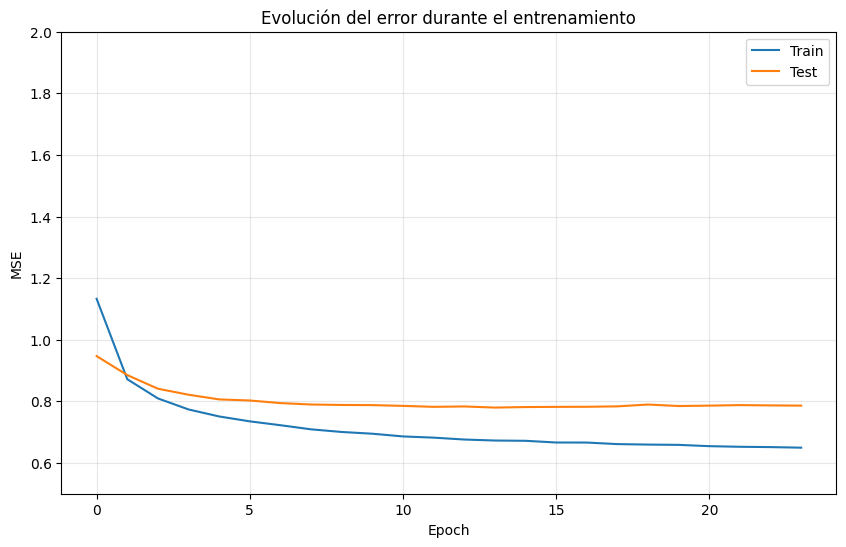

Train MSE final: 0.6495
Test MSE final: 0.7860
Test RMSE: 0.8866


In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Evolución del error durante el entrenamiento')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 2.0)

plt.show()

final_train_mse = history.history['loss'][-1]
final_test_mse = history.history['val_loss'][-1]

print(f'Train MSE final: {final_train_mse:.4f}')
print(f'Test MSE final: {final_test_mse:.4f}')
print(f'Test RMSE: {np.sqrt(final_test_mse):.4f}')

Guardamos el modelo por si es necesario usarlo en el futuro. Usamos el formato `.keras`, que es el recomendado actualmente.

In [17]:
model.save('./models/factorization_matrix.keras')

# Paso 3: Agente LLM para la selección de candidatos

- **3.1.** Recibir la descripción de la película deseada por el usuario (texto libre).

- **3.2.** Obtener el ID del usuario y, utilizando el filtro colaborativo, predecir las valoraciones para las películas no vistas.

- **3.3.** Seleccionar las 10 películas con las mejores valoraciones predichas.

- **3.4.** Extraer información de las 10 películas (géneros y sinopsis) utilizando la librería IMDb.

Cargamos el modelo guardado.

In [18]:
model = load_model('./models/factorization_matrix.keras', custom_objects={
    'MatrixFactorization': MatrixFactorization
})

model.summary()

Model: "matrix_factorization_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_84 (Embedding)        │ (None, 16)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_85 (Embedding)        │ (None, 1)              │           610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_86 (Embedding)        │ (None, 16)             │       155,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_87 (Embedding)        │ (None, 1)              │         9,724 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,036 (2.01 MB)

 Trainable params: 175,678 (686.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 351,358 (1.34 MB)

Primero, recibiremos la información del usuario, tanto de su ID como del texto libre.

In [36]:
# Obtenemos un id de usuario aleatorio de prueba
usuario_prueba = df_ratings['userId'].sample(1).iloc[0]
print(f'Usuario: {usuario_prueba}')
usuario_prueba_idx = codificar_usuario(usuario_prueba, user_to_idx)

# Recibir descripción de película como texto libre
texto = input('¿Qué tipo de película te gustaría ver?: ')

Usuario: 397


A continuación, obtenemos las películas que el usuario no ha visto y hacemos la predicción con el modelo.

In [37]:
df_movies = df_movies_init.copy()

# Obtenemos las películas que no ha visto
peliculas_vistas = df_ratings[df_ratings['users'] == usuario_prueba_idx]
peliculas_no_vistas = set(unique_movies) - set(peliculas_vistas['movieId'])

# Pasamos a tokens para poder usar en el modelo
peliculas_no_vistas_idx = [[codificar_pelicula(x, movie_to_idx)] for x in peliculas_no_vistas]

# Predecimos ratings de películas no vistas
user_movie_array = np.hstack(
    ([[usuario_prueba_idx]] * len(peliculas_no_vistas_idx), peliculas_no_vistas_idx)
)

ratings = model.predict(user_movie_array).flatten()

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Aunque la variable `peliculas_no_vistas` nos da los movieId (sin codificar), para asegurarnos de tener todos correctamente ordenados y sin errores, cogeremos los ID codificados de `user_movie_array` (que es con lo que ha entrenado la red neuronal) y los descodificamos para obtener los ID reales.

In [38]:
peliculas_no_vistas_descodificado = [descodificar_pelicula(x, idx_to_movie) for x in user_movie_array[:, 1]]

Juntamos las películas con los ratings obtenidos y obtenemos un dataframe con los ratings predichos del usuario.

In [39]:
df_predicciones = pd.DataFrame({
    'movieId': peliculas_no_vistas_descodificado,
    'rating': ratings
})

df_predicciones

,movieId,rating
0,1,3.904421
1,2,3.418939
2,3,3.196955
3,4,2.593189
4,5,2.922710
...,...,...
9696,163809,2.976672
9697,98279,3.169236
9698,32743,3.098281
9699,65514,3.430075


Obtenemos las 10 películas con las mejores valoraciones predichas.

In [40]:
# Lista de movieId de las 10 películas que más podrían gustar al usuario
top10_peliculas = df_predicciones.sort_values(by='rating', ascending=False).head(10)['movieId'].to_numpy()

print('Top 10 películas predichas:')
for i in top10_peliculas:
    print(f'   - {df_movies[df_movies['movieId'] == i]['title'].to_numpy()[0]}')

Top 10 películas predichas:
   - Cool Hand Luke (1967)
   - Guess Who's Coming to Dinner (1967)
   - Goodfellas (1990)
   - Shawshank Redemption, The (1994)
   - Notorious (1946)
   - Godfather: Part II, The (1974)
   - American Splendor (2003)
   - Great Dictator, The (1940)
   - Apocalypse Now (1979)
   - Usual Suspects, The (1995)


La librería típica de IMDb (`Cinemagoer`, antes conocida como `IMDbPY`) no funciona para los géneros (probablemente por cambios en la web de IMDb) y lleva dos años descontinuada. Por lo tanto, usaremos una API para conectarnos a **OMDb**, y obtener los datos desde ahí.

Cotejamos los `movieId` obtenidos con los del dataframe `df_links`, obteniendo los códigos de IMDb. Pasamos estos códigos para obtener por API los datos de las películas, tanto de sinopsis como de géneros, y los añadimos a un nuevo dataframe del top 10 de películas más recomendadas.

In [41]:
df_links = df_links_init.copy()

titulos, sinopsis, generos = [], [], []
for pelicula in top10_peliculas:
    # Obtenemos ID de IMDb de la película y ajustamos url
    IMDBID = str(df_links[df_links['movieId'] == pelicula]['imdbId'].iloc[0]).zfill(7)
    url = f'http://www.omdbapi.com/?i=tt{IMDBID}&apikey={OMDB_API_KEY}'

    # Obtenemos los datos
    response = requests.get(url)
    data = response.json()

    if data.get('Response') == 'True':
        title = data.get('Title')
        plot = data.get('Plot')
        genres = data.get('Genre')

        titulos.append(title)
        sinopsis.append(plot)
        generos.append(genres)

    else:
        print(f'Error en película con ID {pelicula}: {data.get('Error')}')

# Creamos dataframe para el top 10 con sinopsis y géneros
df_predicciones_top = df_predicciones.sort_values(by='rating', ascending=False).head(10).copy().reset_index(drop=True)
df_predicciones_top['titulo'] = titulos
df_predicciones_top['sinopsis'] = sinopsis
df_predicciones_top['generos'] = generos

df_predicciones_top

,movieId,rating,titulo,sinopsis,generos
0,1276,4.346656,Cool Hand Luke,A laid-back Southern man is sentenced to two y...,"Crime, Drama"
1,3451,4.336900,Guess Who's Coming to Dinner,A White couple's attitudes are challenged when...,"Comedy, Drama"
2,1213,4.297237,Goodfellas,The story of Henry Hill and his life in the ma...,"Biography, Crime, Drama"
3,318,4.295001,The Shawshank Redemption,A banker convicted of uxoricide forms a friend...,Drama
4,930,4.271644,Notorious,The daughter of a convicted German spy is aske...,"Drama, Film-Noir, Romance"
5,1221,4.269211,The Godfather Part II,The early life and career of Vito Corleone in ...,"Crime, Drama"
6,6620,4.265111,American Splendor,An original mix of fiction and reality illumin...,"Biography, Comedy, Drama"
7,1281,4.257493,The Great Dictator,Dictator Adenoid Hynkel tries to expand his em...,"Comedy, Drama, War"
8,1208,4.255146,Apocalypse Now,A U.S. Army officer serving in Vietnam is task...,"Drama, Mystery, War"
9,50,4.252351,The Usual Suspects,The sole survivor of a pier shoot-out tells th...,"Crime, Drama, Mystery"


Una vez tenemos los datos, usamos un LLM de Groq para que analice la descripción del usuario y mencione si coincide con cada una de las 10 películas.

Para ello, usamos la función `revisar_match_llm_1`, creada en `utils.model_functions.py`. La función toma el texto del usuario y el título, sinopsis y géneros de cada película y devuelve "Sí" o "No" dependiendo de si coincide con lo que se pide.

En base a lo que el modelo devuelve, añadimos en una nueva columna del dataframe un valor booleano para cada película: "True" si coincide y "False" si no coincide.

In [42]:
MODEL_NAME = 'llama-3.3-70b-versatile'

coincide = []
for i in range(len(df_predicciones_top)):
    pelicula = df_predicciones_top.iloc[i]

    respuesta = revisar_match_llm_1(texto, pelicula, GROQ_API_KEY, MODEL_NAME)

    if respuesta in ['Sí', 'Si', 'Sí.', 'Si.']:
        coincide.append(True)
    else:
        coincide.append(False)

df_predicciones_top['coincide'] = coincide

print(f'Texto del usuario: "{texto}"')
print('\nCoincidencias entre película y descripción del usuario:')
df_predicciones_top

Texto del usuario: "Quiero ver una película que me haga reír y que tenga algo de acción"

Coincidencias entre película y descripción del usuario:


,movieId,rating,titulo,sinopsis,generos,coincide
0,1276,4.346656,Cool Hand Luke,A laid-back Southern man is sentenced to two y...,"Crime, Drama",False
1,3451,4.336900,Guess Who's Coming to Dinner,A White couple's attitudes are challenged when...,"Comedy, Drama",True
2,1213,4.297237,Goodfellas,The story of Henry Hill and his life in the ma...,"Biography, Crime, Drama",False
3,318,4.295001,The Shawshank Redemption,A banker convicted of uxoricide forms a friend...,Drama,False
4,930,4.271644,Notorious,The daughter of a convicted German spy is aske...,"Drama, Film-Noir, Romance",False
5,1221,4.269211,The Godfather Part II,The early life and career of Vito Corleone in ...,"Crime, Drama",False
6,6620,4.265111,American Splendor,An original mix of fiction and reality illumin...,"Biography, Comedy, Drama",True
7,1281,4.257493,The Great Dictator,Dictator Adenoid Hynkel tries to expand his em...,"Comedy, Drama, War",True
8,1208,4.255146,Apocalypse Now,A U.S. Army officer serving in Vietnam is task...,"Drama, Mystery, War",False
9,50,4.252351,The Usual Suspects,The sole survivor of a pier shoot-out tells th...,"Crime, Drama, Mystery",False


# Paso 4: Agente LLM para la explicación de la recomendación

Usando el dataframe creado, si ninguna película coincide con la descripción del usuario, se pasa directamente al paso 5. En caso contrario, se pasan a este modelo las que sí coincidan.

De nuevo, definimos la función `elegir_pelicula_llm_2` en `utils.model_functions.py`. La función se encarga de coger las películas que coincidían del top 10, pasarlas al LLM y pedir una recomendación. El modelo da una respuesta en base a la descripción del usuario, la sinopsis, el género y el rating.

In [45]:
coincidencias = False
if df_predicciones_top['coincide'].any():
    coincidencias = True

if coincidencias:
    respuesta = elegir_pelicula_llm_2(texto, df_predicciones_top, GROQ_API_KEY, MODEL_NAME)
    
    print(f'Texto del usuario: {texto}')
    print(f'\nRecomendación sugerida: \n{respuesta}')

else:
    print('Sin coincidencias en top 10. Pasando a recomendar película genérica.')

Texto del usuario: Quiero ver una película que me haga reír y que tenga algo de acción

Recomendación sugerida: 
Parece que buscas una película que te haga reír y tenga algo de acción. Te recomiendo "The Great Dictator" porque creo que es la que más podría gustarte, ya que combina comedia con elementos de drama y guerra, lo que podría proporcionarte la mezcla de acción y humor que estás buscando.


# Paso 5: Agente LLM para recomendación genérica

Si ninguna de las películas del top 10 se parece a lo que el usuario quiere, tenemos que hacer una recomendación genérica. En este caso, no podemos pasarle las casi 10.000 películas registradas, por lo que pasaremos la información disponible a embeddings para poder cotejar los datos. Una vez obtenido los resultados de la búsqueda semántica, le pasamos alguna de las películas al LLM para que elija en función de lo que pide el usuario.

Cotejamos la descripción del usuario con los vectores de las películas, obteniendo 10 películas que se asemejen a lo que pide. Esto se basará principalmente en los géneros, ya que no podemos obtener la descripción de todas las películas de IMDb. Será el LLM el que decida finalmente.

In [46]:
if not coincidencias:
    respuesta = elegir_pelicula_llm_3(texto, GROQ_API_KEY, MODEL_NAME)

    print(f'Texto del usuario: {texto}')
    print(f'Recomendación sugerida: \n{respuesta}')

else:
    print('Ya se recomendó una película por el anterior LLM.')

Ya se recomendó una película por el anterior LLM.
